In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import signal
from scipy.io import wavfile
import numpy as np
from IPython.display import Audio, clear_output
from scipy.signal import fftconvolve
from scipy.fftpack import fft, ifft

Generisanje audio signala

In [2]:
F1 = 200
F2 = 400
F3 = 500
F4 = 700
Fs = 11025
t0 = 0.5
t = np.arange(0,t0,1./Fs)
x1 = np.sin(2 * np.pi * F1 * t )
x2 = np.sin(2 * np.pi * F2 * t )
x3 = np.sin(2 * np.pi * F3 * t )
x4 = np.sin(2 * np.pi * F4 * t )

input_signal = np.concatenate((x1,x2,x3,x4))
input_signal = input_signal / np.max(np.abs(input_signal))
#wavfile.write("input_signal.wav", 11025, input_signal.astype(np.float16)) 

Audio(input_signal,rate = 11025)

In [3]:
#dopunjen nulama do 3 sekunde
input_signal1 = np.zeros(11025*3)
input_signal1[:input_signal.size] = input_signal
#wavfile.write("input_signal_3sec.wav", 11025, input_signal.astype(np.float16))
Audio(input_signal1,rate=11025)

Ucitavanje audio signala

In [5]:
input_audio_file = "acoustic.wav"
Fs, input = wavfile.read(input_audio_file)
input = input / np.max(np.abs(input))

Funkcija za upis u header

In [6]:
def create_c_header(input_signal, filename, sample_rate):
    # Otvaranje datoteke za upis
    with open(filename, 'w') as header_file:
        header_file.write('#ifndef AUDIO_DATA_H_\n')
        header_file.write('#define AUDIO_DATA_H_\n\n')

        # Definisanje frekvencije odmjeravanja
        header_file.write(f'#define SAMPLE_RATE {sample_rate}\n\n')

        # Definisanje duzine niza
        header_file.write(f'#define AUDIO_DATA_LENGTH {len(input_signal)}\n\n')

        # Upis niza podataka ulaznog signala
        header_file.write('float audio_data[] = {\n    ')
        for i, sample in enumerate(input_signal):
            header_file.write(f'{sample:.8f}, ')
            if (i + 1) % 10 == 0:  # nakon svakih 10 uzoraka nova linija
                header_file.write('\n    ')  
            
        header_file.write('\n};\n')

        header_file.write('#endif // AUDIO_DATA_H_\n')


In [7]:
filename = "audio_data.h"
create_c_header(input, filename, sample_rate=Fs)

Funkcije za iscrtavanje signala

In [ ]:
def plotSignals(input_signal,output_signal):
    figure(num=None,figsize=(18,4))
    #t = np.arange( len(input_signal)) / Fs
    plt.plot(input_signal,label="Originalni signal",color="blue")
    plt.plot(output_signal,label="Signal sa efektom",color="orange")
    plt.legend()
    plt.show()

Delay efekat na osnovu dijagrama prikazanog na slici:

![](basic_delay_unit.png)

Implementacija pomocu kruznog bafera

In [9]:
def delay_buff(input_signal, Fs, delay_ms, gain):
    """
    Parametri:
    Ulazni: 
        input   - ulazni niz odmjeraka audio signala
        Fs      - frekvencija odmjeravanja u Hz
        delay_ms- vrijeme kasnjenja u milisekundama
        gain    - pojacanje
     
    return:    output - izlazni zakasnjeni niz odmjeraka
    """
    N = int(Fs * (delay_ms / 1000.0))  # Kasnjenje u odmjercima
    delayline = np.zeros(N + 1)  
    output = np.zeros_like(input_signal)
    for i in range(input_signal.size):
        # Implementacija kruznog bafera
        index = i % (N + 1)
        delay_sample = delayline[index]  # dohvatanje zakasnjenog odmjerka
        delayline[index] = input_signal[i]  # umetanje trenutnog odmjerka
        if i < N:                       # Nema kasnjenja za prvih N odmjeraka
            output[i] = input_signal[i]  
        else:
            output[i] = input_signal[i] + delay_sample * gain  # Sabiranje ulaznog sa zakasnjenim odmjerkom

    # normalizacija
    if np.max(np.abs(output)) != 0:
        output = output / np.max(np.abs(output))
    return output


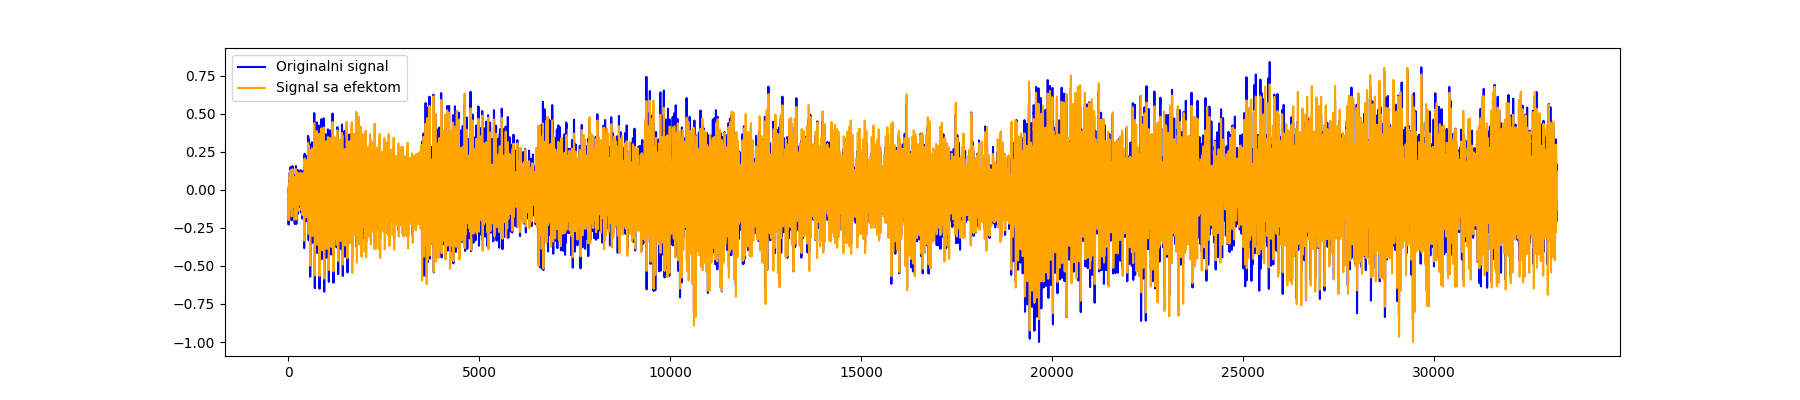

In [10]:
output_delay_buff = delay_buff(input,Fs,100, 0.5)
#plotSignals(input,output_delay_buff)
Audio(output_delay_buff,rate=Fs)


Delay sa feedback petljom implementiran na principu dijagrama prikazanog ispod:

![](basic_delay_unit_with_feedback.png)

In [144]:
#Implementacija koristenjem buffera kao linije za kasnjenje

sample_rate =11025
delay_s = 0.5
N = int(sample_rate * delay_s)   # kasnjenje u odmjercima
index = 0
buffer = np.zeros(N)             # bafer za kasnjenje

def circular_buffer(x):
    global index, buffer, N
    y= buffer[index]
    buffer[index]=x
    index+=1
    index = index % N
    return y

def delay_with_feedback(x, Gff, Gfb):
    after_delay=0
    a=[]
    for i in range(x.size):
        before_delay=x[i]+after_delay*Gfb
        after_delay=circular_buffer(before_delay)
        y=after_delay * Gff + x[i]
        a.append(y)
    return a

Echo

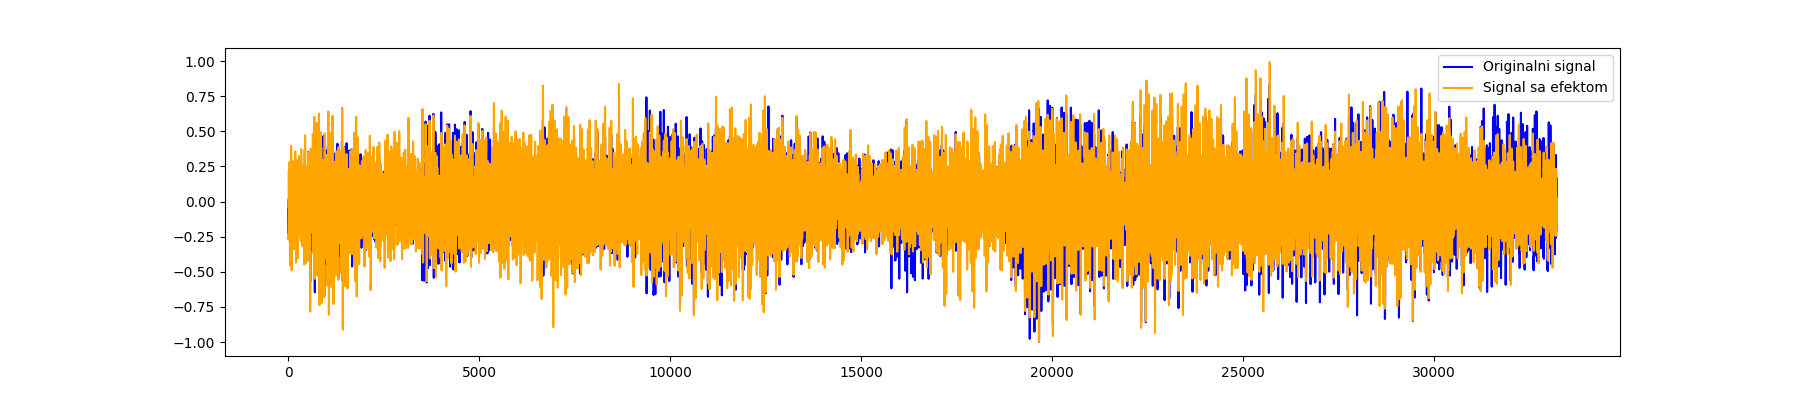

In [183]:
echo_output = delay_with_feedback(input,0.5,0.8)
echo_output = echo_output /np.max(np.abs(echo_output))
#wavfile.write("echo_output.wav", 11025, echo_output.astype(np.float32)) 
plotSignals(input,echo_output)
Audio(echo_output,rate=Fs)

Funkcija za citanje binarnog fajla iz C-a

In [203]:
def read_from_bin(filename):
    #otvaranje binarne datoteke za citanje
    with open(filename,'rb') as file:
        audio_data = file.read()  #audio odmjerci u bajtovima
    #konverzija bajtova y NumPy niz
    audio_samples = np.frombuffer(audio_data,dtype=np.float32)
    
    return audio_samples

Tremolo

![](tremolo.png)

In [185]:
def tremolo(input_signal,Fs,Flfo,alpha):
        """
        Ulazni parametri:
        input_signal    -   ulazni audio signal
        Fs              -   frekvencija oscilovanja u Hz
        Flfo            -  frekvencija modulacije (<20Hz)
        alpha (float)   -   faktor dubine modulacije, ukazuje koliiko ce amplitudna modulacija uticati na amplitudu originalnog signala,izmedju 0 i 1
        
        :returns:          -   izlazni audio signal nad kojim je primijenjen efekat
        
        """
        y = np.zeros(len(input_signal))
        for i in range(len(input_signal)):
            m = (1+alpha*np.sin(2*np.pi*i*(Flfo/Fs)))
            y[i] = m * input_signal[i]
        
        y = y/np.max(np.abs(y)) 
        return y


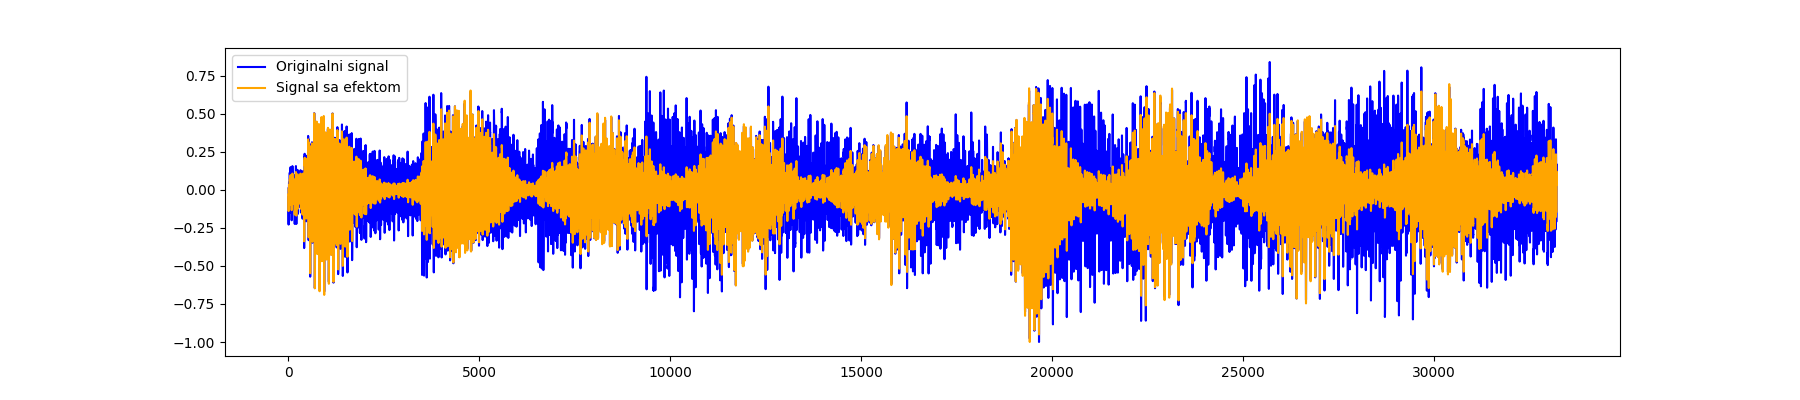

In [205]:
tremolo_output =tremolo(input,Fs,3,0.7)
plotSignals(input,tremolo_output)
Audio(tremolo_output,rate=Fs)

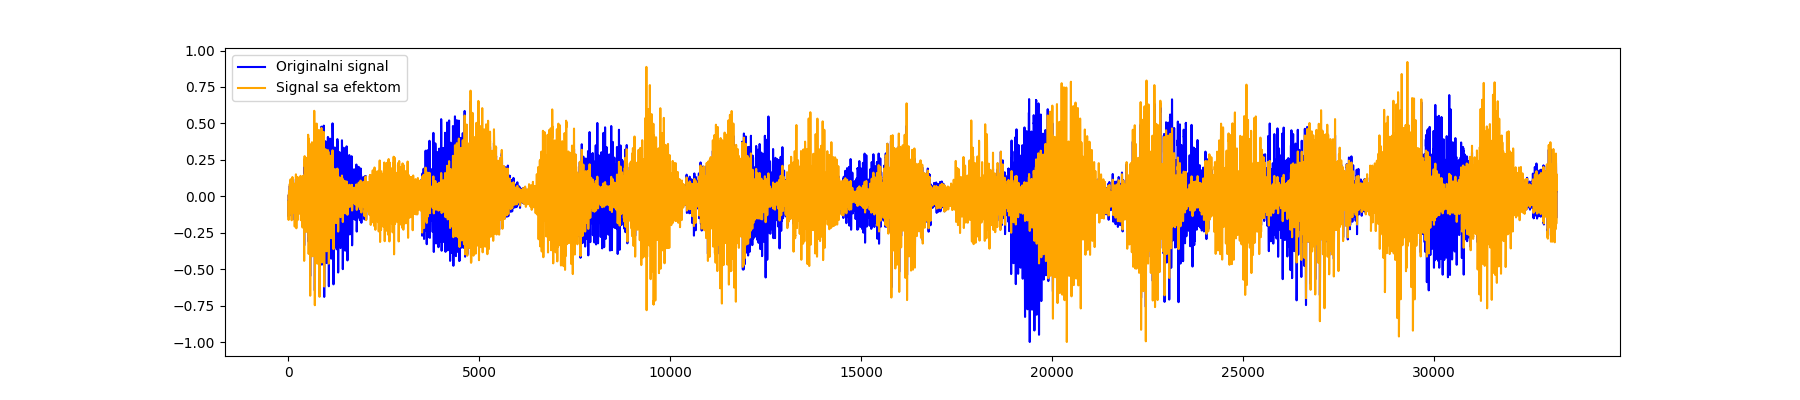

In [207]:
tremolo_from_C = read_from_bin("output_data_tremolo.bin")
plotSignals(tremolo_output,tremolo_from_C)
Audio(tremolo_from_C,rate=Fs)

Flanger 

![](basic_flanger_without_feedback.png)

In [191]:
def flanger(input_signal, Fs, Flfo, delay_ms, gain):
    """
    Primjena flanger efekta na ulazni audio signal

    Ulazni parametri:
    input_signal -   ulazni audio signal
    Fs           -   frekvencija odmjeravanja (Hz)
    Flfo         -   frekvencija oscilatora (~1Hz)                
    delay_ms     -   maksimalno željeno kašnjenje u milisekundama(0-15ms)
    gain         -   pojačanje, od 0 do 1     
    
    Return:      
    Audio signal sa primijenjenim flanger efektom
    """

    #maksimalno kasnjenje u broju odmjeraka
    N = (delay_ms / 1000) * Fs

    output_signal = np.zeros(len(input_signal))

    for i in range(len(input_signal)):
        d = int((N / 2) * (1 + np.sin(2 * np.pi * i *(Flfo/ Fs))))
        if d <= N:
            output_signal[i] = input_signal[i] + (gain * input_signal[(i - d)])
        else:
            output_signal[i] = input_signal[i]

    output_signal = output_signal/np.max(np.abs(output_signal))
    return output_signal

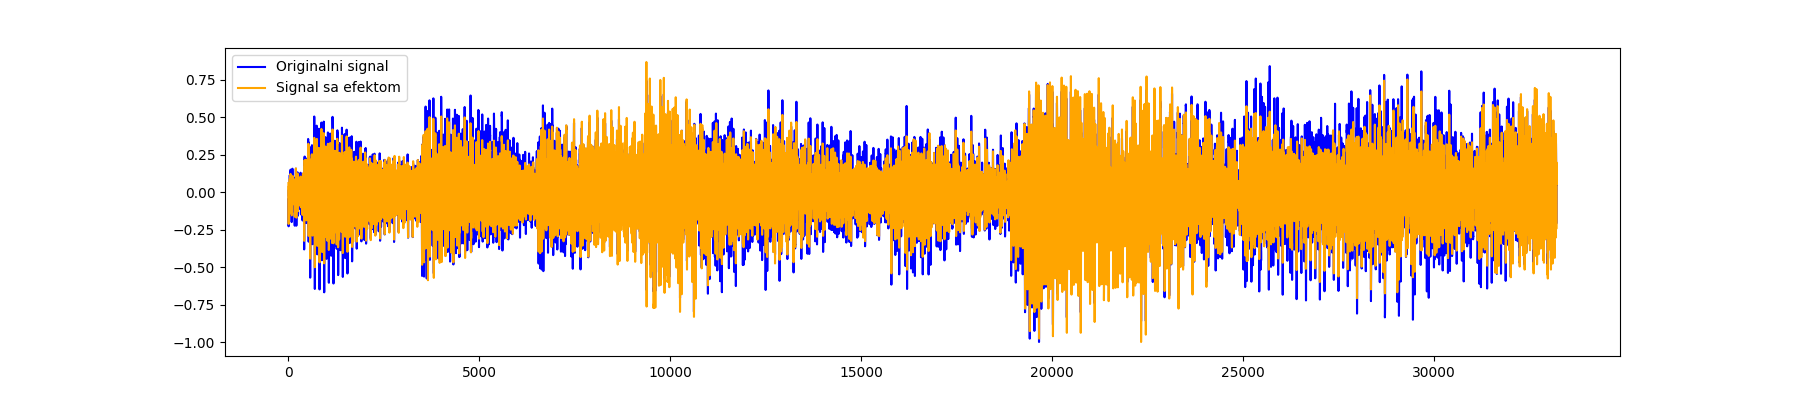

In [193]:
flanger_output = flanger(input,Fs,0.9,3.0,0.4)
plotSignals(input,flanger_output)
Audio(flanger_output,rate=Fs)

In [194]:
def flanger_buffer(input_signal, Fs, Flfo, delay_ms, gain):
    """
    Primjena flanger efekta na ulazni audio signal koristeći kružni bafer za kašnjenje.

    Ulazni parametri:
    input_signal    - Ulazni audio signal.
    Fs              - Frekvencija odmjeravanja (Hz).
    Flfo            - Frekvencija oscilatora (Hz).
    delay_ms        - Maksimalno željeno kašnjenje u milisekundama (0-15ms).
    gain            - Pojačanje, od 0 do 1.

    Returns:
    Audio signal sa primijenjenim flanger efektom.
    """
    # Maksimalno kašnjenje u broju uzoraka
    max_delay_samples = int((delay_ms / 1000) * Fs)
    delay_buffer = np.zeros(max_delay_samples)  # Kružni bafer
    write_pointer = 0  # Pokazivač za upis

    output_signal = np.zeros(len(input_signal))

    for i in range(len(input_signal)):
        # Modulacija kašnjenja pomoću LFO
        delay_samples = int((max_delay_samples / 2) * (1 + np.sin(2 * np.pi * i * (Flfo / Fs))))

        # Izračunavanje pozicije za čitanje iz kružnog bafera
        read_pointer = (write_pointer - delay_samples + max_delay_samples) % max_delay_samples

        # Čitanje uzorka iz kružnog bafera
        delayed_sample = delay_buffer[read_pointer]

        # Dodavanje efektiranog uzorka na ulazni signal
        output_signal[i] = input_signal[i] + (gain * delayed_sample)

        # Ažuriranje kružnog bafera
        delay_buffer[write_pointer] = input_signal[i]
        write_pointer = (write_pointer + 1) % max_delay_samples

    # Normalizacija izlaznog signala može biti opcionalna zavisno od željenog izlaznog nivoa
    output_signal = output_signal / np.max(np.abs(output_signal))
    return output_signal


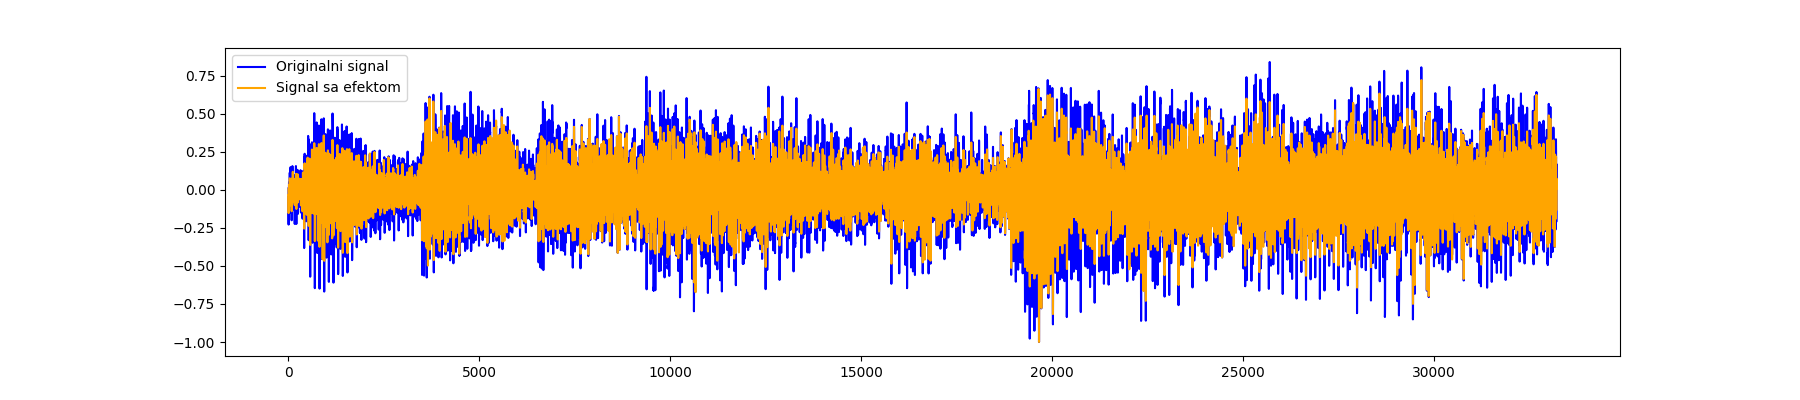

In [195]:
flanger_buff = flanger_buffer(input,Fs,1,10,0.5)
plotSignals(input,flanger_buff)
Audio(flanger_buff,rate=Fs)

WahWah

In [197]:
def compute_biquad_coefficients(fs, f0, Q):
    """
    Izračunava koeficijente za BiQuad band-pass filter.
    
    Ulazni parametri:
        fs (float): Frekvencija uzorkovanja u Hz.
        f0 (float): Centralna frekvencija filtra u Hz.
        Q (float): Faktor kvaliteta filtra.
    
    Returns:
        (b0, b1, b2, a0, a1, a2): Koeficijenti filtra.
    """
    w0 = 2 * np.pi * f0 / fs
    alpha = np.sin(w0) / (2 * Q)

    b0 = alpha
    b1 = 0.0
    b2 = -alpha
    a0 = 1 + alpha
    a1 = -2 * np.cos(w0)
    a2 = 1 - alpha

    return b0, b1, b2, a0, a1, a2

def wahwah_effect(input_signal, fs, f_min, f_max, Q, lfo_rate):
    """
    Primjenjuje wah-wah efekat na ulazni signal koristeći BiQuad filter.
    
    Ulazni parametri:
        input_signal - Ulazni audio signal.
        fs - Frekvencija uzorkovanja u Hz.
        f_min - Minimalna centralna frekvencija filtra.
        f_max - Maksimalna centralna frekvencija filtra.
        Q - Faktor kvaliteta filtra.
        lfo_rate - Brzina LFO-a u Hz.
    
    Returns:
        Audio signal sa primenjenim wah-wah efektom.
    """
    output_signal = np.zeros(len(input_signal))
    lfo = np.sin(2 * np.pi * np.arange(len(input_signal)) * lfo_rate / fs)
    f0 = f_min + (f_max - f_min) * (lfo + 1) / 2

    for i in range(len(input_signal)):
        b0, b1, b2, a0, a1, a2 = compute_biquad_coefficients(fs, f0[i], Q)
        if i >= 2:
            output_signal[i] = (b0/a0)*input_signal[i] + (b1/a0)*input_signal[i-1] + (b2/a0)*input_signal[i-2] - (a1/a0)*output_signal[i-1] - (a2/a0)*output_signal[i-2]
    output_signal = output_signal/np.max(np.abs(output_signal))

    return output_signal


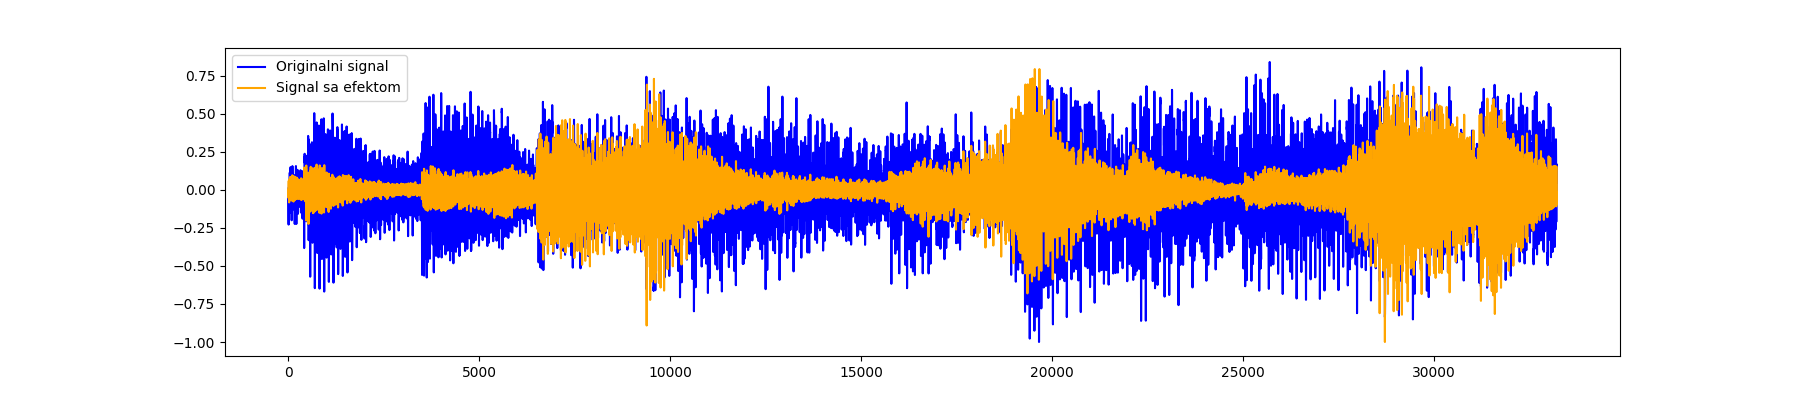

In [199]:
wah_wah_output = wahwah_effect(input,Fs,500, 3000,2.5,1)
plotSignals(input,wah_wah_output)
Audio(wah_wah_output,rate=Fs)

Reverb

In [200]:
def fconv(x,h):
    ly = len(x)+len(h) -1
   
    X = fft(x, ly)
    H = fft(h, ly)
    
    Y = X * H  # convolution
    y = np.real(ifft(Y,ly))
    y=y/np.max(np.abs(y))
    return y


impulse_response_file = "impulse_cathedral.wav"
s, h1 = wavfile.read(impulse_response_file)

h1 = h1/np.max(np.abs(h1))

y = fconv(input,h1)


Audio(y,rate=Fs)

